In [1]:
!pip install -q transformers==4.43.0 datasets==2.20.0 huggingface_hub==0.24.5 albumentations==1.4.7 timm==0.9.16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 63.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 85.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:0

In [2]:
import os, random, math, json, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from huggingface_hub import hf_hub_download, create_repo, upload_file
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

2025-07-24 01:48:29.131643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753321709.339134      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753321709.396532      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
from huggingface_hub import hf_hub_download
import zipfile
import os

# Descargar el archivo desde el repo
zip_path = hf_hub_download(
    repo_id="JGuevara-12/inria-tiles-sampled",
    repo_type="dataset",
    filename="tiles_sampled_train.zip"
)

tiles_sampled_train.zip:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

In [6]:
# Extraer el zip
extract_to = "tiles"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Dataset extraído a: {extract_to}/")

✅ Dataset extraído a: tiles/


In [7]:
from pathlib import Path
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor


In [8]:
IMG_DIR = Path("tiles/images")
MSK_DIR = Path("tiles/masks")

all_images = sorted(list(IMG_DIR.glob("*.png")))
print("Total de imágenes:", len(all_images))


Total de imágenes: 2729


In [9]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
TARGET_SIZE = processor.size["height"]  # normalmente 512

train_tfms = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=processor.image_mean, std=processor.image_std),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE),
    A.Normalize(mean=processor.image_mean, std=processor.image_std),
    ToTensorV2()
])


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, msk_dir, transform):
        self.img_paths = sorted(list(Path(img_dir).glob("*.png")))
        self.msk_paths = [Path(msk_dir)/p.name for p in self.img_paths]
        self.transform = transform
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_paths[idx]).convert("RGB"))
        msk = np.array(Image.open(self.msk_paths[idx]).convert("L"))
        msk = (msk > 127).astype(np.uint8)
        aug = self.transform(image=img, mask=msk)
        return aug["image"], aug["mask"].long()

full_indices = list(range(len(all_images)))
random.shuffle(full_indices)
val_ratio = 0.2
n_val = int(len(full_indices)*val_ratio)
val_indices = full_indices[:n_val]
train_indices = full_indices[n_val:]

def subset(indices, transform):
    class _Sub(Dataset):
        def __init__(self, idxs): self.idxs = idxs
        def __len__(self): return len(self.idxs)
        def __getitem__(self, i):
            k = self.idxs[i]
            img = np.array(Image.open(all_images[k]).convert("RGB"))
            msk = np.array(Image.open(MSK_DIR/all_images[k].name).convert("L"))
            msk = (msk > 127).astype(np.uint8)
            aug = transform(image=img, mask=msk)
            return aug["image"], aug["mask"].long()
    return _Sub(indices)

train_ds = subset(train_indices, train_tfms)
val_ds   = subset(val_indices, val_tfms)

print("Train:", len(train_ds), "Val:", len(val_ds))


Train: 2184 Val: 545


In [11]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)


In [12]:
id2label = {0: "background", 1: "building"}
label2id = {v:k for k,v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(device)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch.nn as nn

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    inter = (probs * targets).sum(dim=(2,3))
    denom = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + eps
    dice = 2*inter/denom
    return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, pos_weight=None, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice_weight = dice_weight
    def forward(self, logits, targets):
        # logits: [B,2,H,W]; usamos canal 1 (building)
        building = logits[:,1:2]
        bce = self.bce(building, targets.unsqueeze(1).float())
        dsc = dice_loss(building, targets.unsqueeze(1))
        return (1-self.dice_weight)*bce + self.dice_weight*dsc

# Aproximar pos_weight leyendo algunos batches
pos_pixels = 0
neg_pixels = 0
for i,(x,y) in enumerate(train_loader):
    pos_pixels += y.sum().item()
    neg_pixels += (y.numel() - y.sum().item())
    if i > 10:  # unos cuantos batches bastan
        break
ratio = neg_pixels / max(pos_pixels,1)
pos_weight = torch.tensor([ratio], device=device)
print("pos_weight ≈", pos_weight.item())

loss_fn = BCEDiceLoss(pos_weight=pos_weight, dice_weight=0.5)


pos_weight ≈ 1.8749113082885742


In [14]:
import math
from pathlib import Path

EPOCHS = 30
PATIENCE = 5
GRAD_CLIP_NORM = 1.0
WARMUP_EPOCHS = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# LR scheduler (warmup + cosine), paso por batch
total_steps = len(train_loader) * EPOCHS
warmup_steps = len(train_loader) * WARMUP_EPOCHS
def lr_lambda(step: int):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# GradScaler (API nueva con fallback)
try:
    from torch import amp
    scaler = amp.GradScaler('cuda') if device.type == 'cuda' else None
    autocast_ctx = torch.autocast(device_type='cuda', dtype=torch.float16, enabled=(device.type=='cuda'))
except Exception:
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    autocast_ctx = torch.cuda.amp.autocast(enabled=(device.type=='cuda'))

best_iou = 0.0
pat_counter = 0
save_dir = Path('checkpoints'); save_dir.mkdir(exist_ok=True)


In [15]:
import torch.nn.functional as F

history = {k: [] for k in ['train_loss','val_loss','val_iou','val_f1','lr']}

try:
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for imgs, msks in tqdm(train_loader, desc=f'Epoch {epoch} [train]'):
            imgs, msks = imgs.to(device), msks.to(device)
            optimizer.zero_grad()
            with autocast_ctx:
                logits = model(pixel_values=imgs).logits
                if logits.shape[-1] != msks.shape[-1]:
                    logits = F.interpolate(logits, size=msks.shape[-2:], mode='bilinear', align_corners=False)
                loss = loss_fn(logits, msks)

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                optimizer.step()

            scheduler.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)

        # Validación
        model.eval()
        val_loss = 0.0
        agg_tp = agg_fp = agg_fn = 0
        with torch.inference_mode():
            for imgs, msks in tqdm(val_loader, desc=f'Epoch {epoch} [val]'):
                imgs, msks = imgs.to(device), msks.to(device)
                with autocast_ctx:
                    logits = model(pixel_values=imgs).logits
                    if logits.shape[-1] != msks.shape[-1]:
                        logits = F.interpolate(logits, size=msks.shape[-2:], mode='bilinear', align_corners=False)
                    loss = loss_fn(logits, msks)
                val_loss += loss.item() * imgs.size(0)
                preds = logits.argmax(dim=1)
                agg_tp += ((preds == 1) & (msks == 1)).sum().item()
                agg_fp += ((preds == 1) & (msks == 0)).sum().item()
                agg_fn += ((preds == 0) & (msks == 1)).sum().item()
        val_loss /= len(val_loader.dataset)
        precision = agg_tp / (agg_tp + agg_fp + 1e-6)
        recall = agg_tp / (agg_tp + agg_fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        iou = agg_tp / (agg_tp + agg_fp + agg_fn + 1e-6)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(iou)
        history['val_f1'].append(f1)
        history['lr'].append(current_lr)

        print(f"Epoch {epoch}: lr={current_lr:.2e} train_loss={train_loss:.4f} "
              f"val_loss={val_loss:.4f} IoU={iou:.4f} F1={f1:.4f}")

        if iou > best_iou:
            best_iou = iou
            pat_counter = 0
            torch.save({'model_state': model.state_dict(), 'iou': iou}, save_dir / 'best.pt')
            print("↳ Nuevo mejor modelo guardado.")
        else:
            pat_counter += 1
            if pat_counter >= PATIENCE:
                print("Early stopping activado.")
                break

except KeyboardInterrupt:
    print("Entrenamiento interrumpido manualmente. Guardando último mejor modelo…")
    torch.save({'model_state': model.state_dict(), 'iou': best_iou}, save_dir / 'best_interrupt.pt')


Epoch 1 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 1 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1: lr=2.50e-05 train_loss=0.6045 val_loss=0.4173 IoU=0.6211 F1=0.7663
↳ Nuevo mejor modelo guardado.


Epoch 2 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 2 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2: lr=5.00e-05 train_loss=0.3915 val_loss=0.3110 IoU=0.7152 F1=0.8340
↳ Nuevo mejor modelo guardado.


Epoch 3 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 3 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3: lr=4.98e-05 train_loss=0.3208 val_loss=0.2856 IoU=0.7360 F1=0.8479
↳ Nuevo mejor modelo guardado.


Epoch 4 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 4 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4: lr=4.94e-05 train_loss=0.2940 val_loss=0.2741 IoU=0.7498 F1=0.8570
↳ Nuevo mejor modelo guardado.


Epoch 5 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 5 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5: lr=4.86e-05 train_loss=0.2779 val_loss=0.2663 IoU=0.7556 F1=0.8608
↳ Nuevo mejor modelo guardado.


Epoch 6 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 6 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6: lr=4.75e-05 train_loss=0.2688 val_loss=0.2613 IoU=0.7572 F1=0.8618
↳ Nuevo mejor modelo guardado.


Epoch 7 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 7 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7: lr=4.62e-05 train_loss=0.2618 val_loss=0.2509 IoU=0.7635 F1=0.8659
↳ Nuevo mejor modelo guardado.


Epoch 8 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 8 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8: lr=4.45e-05 train_loss=0.2563 val_loss=0.2461 IoU=0.7652 F1=0.8670
↳ Nuevo mejor modelo guardado.


Epoch 9 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 9 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9: lr=4.27e-05 train_loss=0.2486 val_loss=0.2456 IoU=0.7687 F1=0.8692
↳ Nuevo mejor modelo guardado.


Epoch 10 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 10 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 

Epoch 10: lr=4.06e-05 train_loss=0.2434 val_loss=0.2470 IoU=0.7631 F1=0.8656


Epoch 11 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 11 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11: lr=3.83e-05 train_loss=0.2405 val_loss=0.2404 IoU=0.7743 F1=0.8728
↳ Nuevo mejor modelo guardado.


Epoch 12 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>^^
^^^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils

Epoch 12 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12: lr=3.58e-05 train_loss=0.2377 val_loss=0.2375 IoU=0.7768 F1=0.8744
↳ Nuevo mejor modelo guardado.


Epoch 13 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 13 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13: lr=3.33e-05 train_loss=0.2323 val_loss=0.2370 IoU=0.7738 F1=0.8725


Epoch 14 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 14 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14: lr=3.06e-05 train_loss=0.2302 val_loss=0.2362 IoU=0.7796 F1=0.8761
↳ Nuevo mejor modelo guardado.


Epoch 15 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 15 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15: lr=2.78e-05 train_loss=0.2263 val_loss=0.2341 IoU=0.7802 F1=0.8765
↳ Nuevo mejor modelo guardado.


Epoch 16 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 16 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 16: lr=2.50e-05 train_loss=0.2243 val_loss=0.2327 IoU=0.7796 F1=0.8762


Epoch 17 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 17 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 17: lr=2.22e-05 train_loss=0.2224 val_loss=0.2326 IoU=0.7797 F1=0.8762


Epoch 18 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 18 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Exception ignored in:         self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
      File "/usr/local/lib/python3.11/dist-packages/

Epoch 18: lr=1.94e-05 train_loss=0.2201 val_loss=0.2314 IoU=0.7799 F1=0.8763


Epoch 19 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 19 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 19: lr=1.67e-05 train_loss=0.2185 val_loss=0.2304 IoU=0.7817 F1=0.8774
↳ Nuevo mejor modelo guardado.


Epoch 20 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():        
 se

Epoch 20 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 20: lr=1.42e-05 train_loss=0.2154 val_loss=0.2309 IoU=0.7818 F1=0.8775
↳ Nuevo mejor modelo guardado.


Epoch 21 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 21 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 21: lr=1.17e-05 train_loss=0.2133 val_loss=0.2298 IoU=0.7847 F1=0.8793
↳ Nuevo mejor modelo guardado.


Epoch 22 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 22 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 22: lr=9.41e-06 train_loss=0.2154 val_loss=0.2295 IoU=0.7832 F1=0.8784


Epoch 23 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 23 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 23: lr=7.32e-06 train_loss=0.2124 val_loss=0.2301 IoU=0.7856 F1=0.8799
↳ Nuevo mejor modelo guardado.


Epoch 24 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 24 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 24: lr=5.45e-06 train_loss=0.2111 val_loss=0.2299 IoU=0.7861 F1=0.8802
↳ Nuevo mejor modelo guardado.


Epoch 25 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 25 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 25: lr=3.83e-06 train_loss=0.2106 val_loss=0.2300 IoU=0.7866 F1=0.8805
↳ Nuevo mejor modelo guardado.


Epoch 26 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 26 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 26: lr=2.48e-06 train_loss=0.2107 val_loss=0.2296 IoU=0.7865 F1=0.8805


Epoch 27 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 27 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>self._shutdown_workers()

Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
if w.is_alive():Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in 

Epoch 27: lr=1.40e-06 train_loss=0.2123 val_loss=0.2287 IoU=0.7865 F1=0.8805


Epoch 28 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 28 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 28: lr=6.27e-07 train_loss=0.2098 val_loss=0.2284 IoU=0.7869 F1=0.8807
↳ Nuevo mejor modelo guardado.


Epoch 29 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^^^^ ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>Exception ignored in: ^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b103432bd80>^^Traceback (mos

Epoch 29 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 29: lr=1.57e-07 train_loss=0.2101 val_loss=0.2280 IoU=0.7859 F1=0.8801


Epoch 30 [train]:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch 30 [val]:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 30: lr=0.00e+00 train_loss=0.2090 val_loss=0.2284 IoU=0.7864 F1=0.8805


✅ Mejor IoU validación: 0.7869


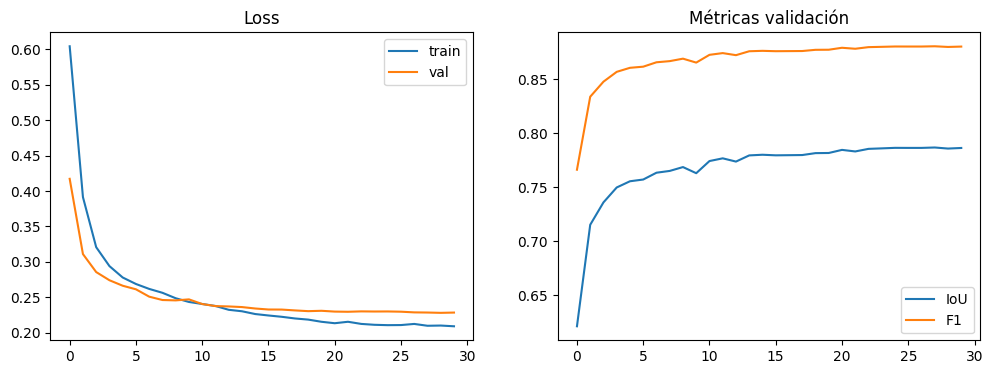

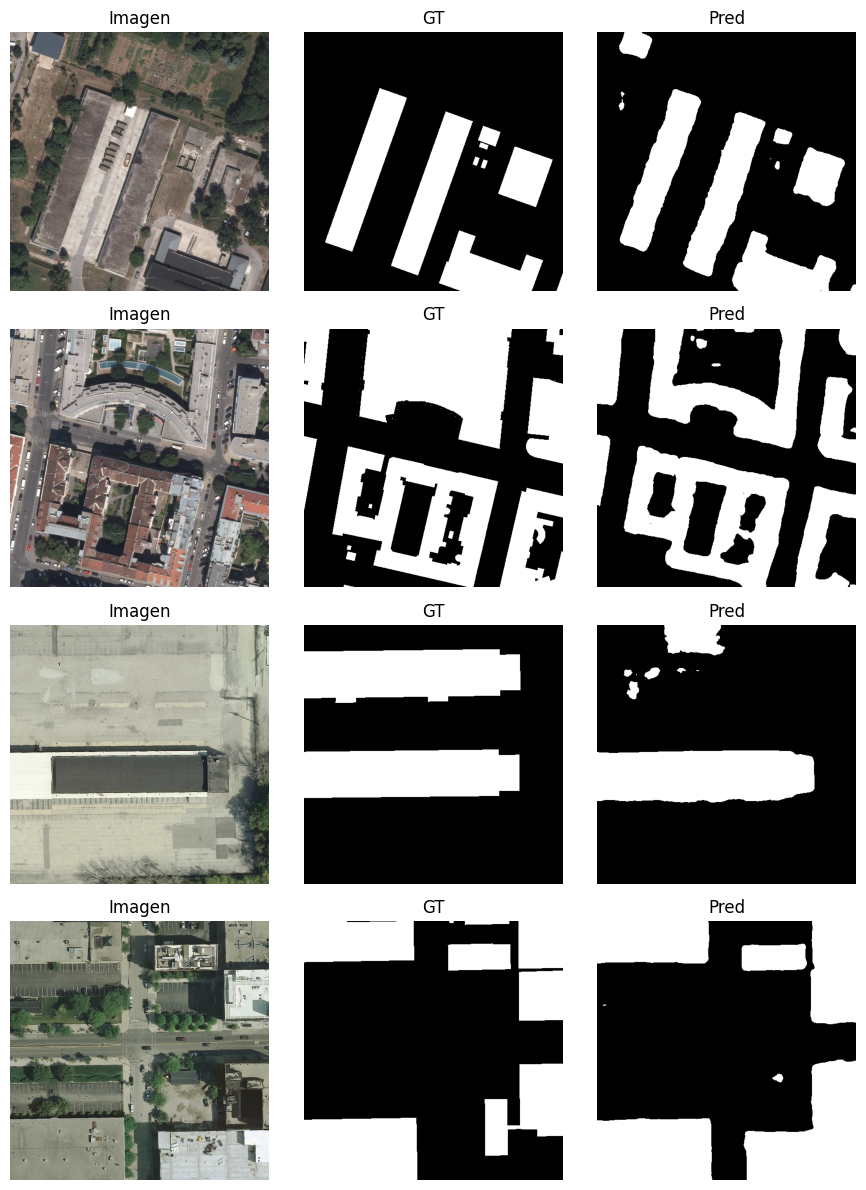

Calculando PRC:   0%|          | 0/137 [00:00<?, ?it/s]

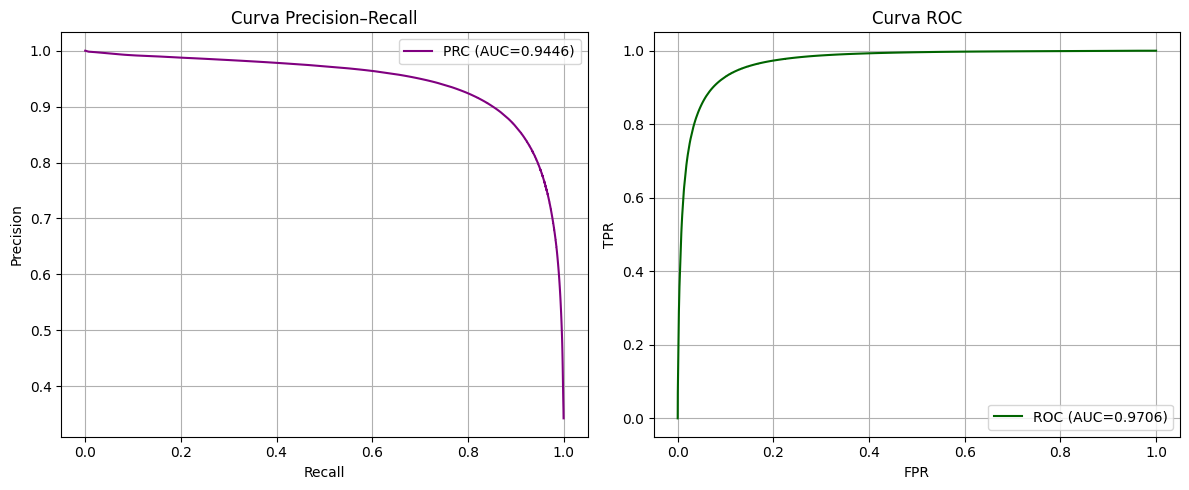

In [23]:
# === Evaluación final y visualización ===
import matplotlib.pyplot as plt

# Cargar mejor checkpoint
ckpt = torch.load(save_dir / 'best.pt', map_location=device)
model.load_state_dict(ckpt['model_state'])
print(f"✅ Mejor IoU validación: {ckpt['iou']:.4f}")

# Curvas de entrenamiento
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history['val_iou'], label='IoU')
plt.plot(history['val_f1'], label='F1')
plt.title('Métricas validación'); plt.legend()
plt.show()

# Visualización de predicciones
model.eval()
imgs, msks = next(iter(val_loader))
imgs = imgs.to(device)
with torch.inference_mode():
    logits = model(pixel_values=imgs).logits
    if logits.shape[-1] != msks.shape[-1]:
        logits = F.interpolate(logits, size=msks.shape[-2:], mode='bilinear', align_corners=False)
preds = logits.argmax(dim=1).cpu()

# Función para desnormalizar
def denorm(t):
    mean = torch.tensor(processor.image_mean).view(3,1,1)
    std = torch.tensor(processor.image_std).view(3,1,1)
    return (t.cpu() * std + mean).clamp(0,1)

n = min(4, imgs.size(0))
fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
for i in range(n):
    axes[i,0].imshow(denorm(imgs[i]).permute(1,2,0)); axes[i,0].set_title('Imagen'); axes[i,0].axis('off')
    axes[i,1].imshow(msks[i].cpu(), cmap='gray'); axes[i,1].set_title('GT'); axes[i,1].axis('off')
    axes[i,2].imshow(preds[i], cmap='gray'); axes[i,2].set_title('Pred'); axes[i,2].axis('off')
plt.tight_layout(); plt.show()


# === Curvas PRC y ROC (por píxel, clase "building") ===
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
all_probs = []
all_labels = []

with torch.inference_mode():
    for imgs, msks in tqdm(val_loader, desc="Calculando PRC"):
        imgs, msks = imgs.to(device), msks.to(device)
        logits = model(pixel_values=imgs).logits
        if logits.shape[-1] != msks.shape[-1]:
            logits = F.interpolate(logits, size=msks.shape[-2:], mode='bilinear', align_corners=False)
        
        probs = torch.sigmoid(logits[:,1])  # Canal building
        all_probs.append(probs.cpu().flatten())
        all_labels.append(msks.cpu().flatten())

# Concatenar predicciones y etiquetas
y_probs = torch.cat(all_probs).numpy()
y_true = torch.cat(all_labels).numpy()

# PRC y ROC
prec, rec, pr_thresholds = precision_recall_curve(y_true, y_probs)
fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)
auc_pr = auc(rec, prec)
auc_roc = auc(fpr, tpr)

# Visualización
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rec, prec, label=f'PRC (AUC={auc_pr:.4f})', color='purple')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Curva Precision–Recall')
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_roc:.4f})', color='darkgreen')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Curva ROC')
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


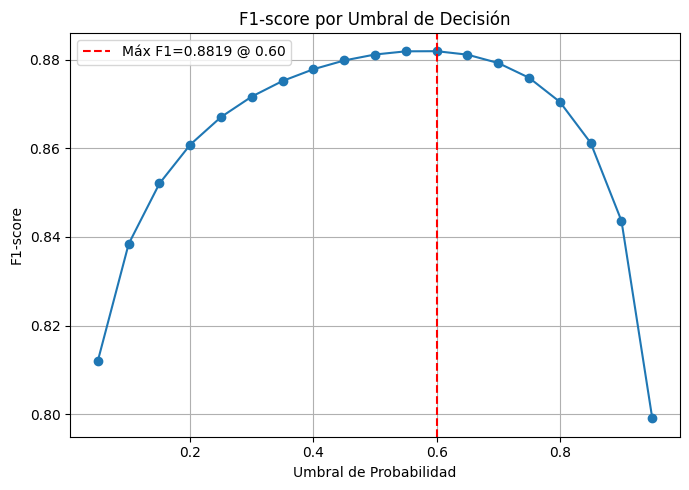

✅ Mejor umbral: 0.60 con F1=0.8819


In [24]:
# === Gráfica de F1-score en función del umbral ===
f1_scores = []
thresholds = np.linspace(0.05, 0.95, 19)

for thresh in thresholds:
    preds_bin = (y_probs >= thresh).astype(np.uint8)
    tp = ((preds_bin == 1) & (y_true == 1)).sum()
    fp = ((preds_bin == 1) & (y_true == 0)).sum()
    fn = ((preds_bin == 0) & (y_true == 1)).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    f1_scores.append(f1)

best_idx = int(np.argmax(f1_scores))
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máx F1={best_f1:.4f} @ {best_thresh:.2f}')
plt.title('F1-score por Umbral de Decisión')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Mejor umbral: {best_thresh:.2f} con F1={best_f1:.4f}")


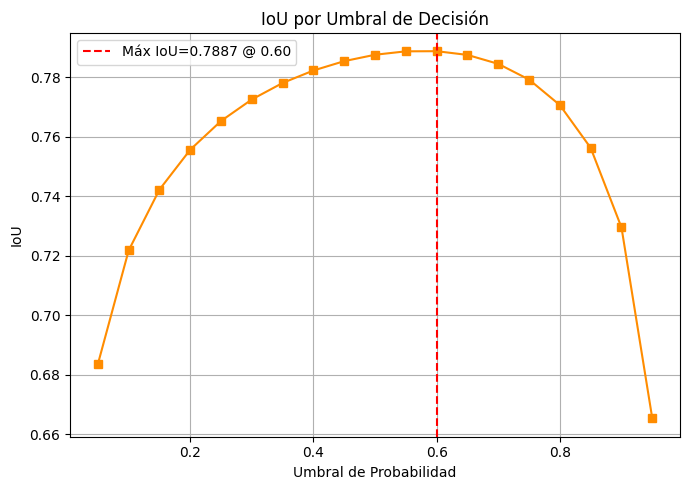

✅ Mejor umbral para IoU: 0.60 con IoU=0.7887


In [25]:
# === Curva de IoU en función del umbral ===
iou_scores = []

for thresh in thresholds:
    preds_bin = (y_probs >= thresh).astype(np.uint8)
    tp = ((preds_bin == 1) & (y_true == 1)).sum()
    fp = ((preds_bin == 1) & (y_true == 0)).sum()
    fn = ((preds_bin == 0) & (y_true == 1)).sum()
    iou = tp / (tp + fp + fn + 1e-6)
    iou_scores.append(iou)

best_idx_iou = int(np.argmax(iou_scores))
best_thresh_iou = thresholds[best_idx_iou]
best_iou = iou_scores[best_idx_iou]

plt.figure(figsize=(7,5))
plt.plot(thresholds, iou_scores, marker='s', color='darkorange')
plt.axvline(x=best_thresh_iou, color='red', linestyle='--', label=f'Máx IoU={best_iou:.4f} @ {best_thresh_iou:.2f}')
plt.title('IoU por Umbral de Decisión')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('IoU')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Mejor umbral para IoU: {best_thresh_iou:.2f} con IoU={best_iou:.4f}")


In [27]:
# =========================================
# Inferencia masiva y generación de meta_segment.csv
# =========================================
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

ARTIFACT_DIR = Path("artifacts/segment")
MASKS_DIR = ARTIFACT_DIR / "masks"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
MASKS_DIR.mkdir(parents=True, exist_ok=True)
META_PATH = ARTIFACT_DIR / "meta_segment.csv"

def segment_image(img_path: Path) -> dict:
    """Segmenta una sola imagen y devuelve métricas."""
    img = np.array(Image.open(img_path).convert("RGB"))
    # Usamos val_tfms para garantizar mismas normalizaciones
    augmented = val_tfms(image=img, mask=np.zeros(img.shape[:2], dtype=np.uint8))
    tensor = augmented["image"].unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = model(pixel_values=tensor).logits
        if logits.shape[-1] != img.shape[1]:
            logits = F.interpolate(
                logits, size=img.shape[:2], mode="bilinear", align_corners=False
            )
        pred = logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)

    # Guardar máscara binaria
    mask_path = MASKS_DIR / img_path.name
    Image.fromarray(pred * 255).save(mask_path)

    roof_area_px = int(pred.sum())
    roof_ratio = roof_area_px / pred.size
    return {
        "image_id": img_path.name,
        "mask_path": str(mask_path),
        "roof_area_px": roof_area_px,
        "roof_ratio": roof_ratio,
    }

# Si existe, cargamos para no repetir (permite re-ejecutar sin perder trabajo)
if META_PATH.exists():
    meta_df = pd.read_csv(META_PATH)
    processed = set(meta_df["image_id"].tolist())
else:
    meta_df = pd.DataFrame(columns=["image_id", "mask_path", "roof_area_px", "roof_ratio"])
    processed = set()

rows = []
for img_path in tqdm(all_images, desc="Inferencia masiva (segmentación)"):
    if img_path.name in processed:
        continue
    try:
        rows.append(segment_image(img_path))
    except Exception as e:
        print(f"[WARN] Error procesando {img_path.name}: {e}")

if rows:
    meta_df = pd.concat([meta_df, pd.DataFrame(rows)], ignore_index=True)
    meta_df.to_csv(META_PATH, index=False)

print(f"✅ meta_segment.csv generado en: {META_PATH.resolve()}")


Inferencia masiva (segmentación):   0%|          | 0/2729 [00:00<?, ?it/s]

✅ meta_segment.csv generado en: /kaggle/working/artifacts/segment/meta_segment.csv


In [29]:
# === Subir modelo a Hugging Face Hub (robusto) ===
import os, json, torch
import torch.nn as nn
from pathlib import Path
from huggingface_hub import create_repo, upload_folder, HfApi

USERNAME = "jobejaranom"
REPO_ID = f"{USERNAME}/segformer-inria-binary"

# 1. Cargar mejor checkpoint
ckpt_path = save_dir / "best.pt"
assert ckpt_path.exists(), f"No existe {ckpt_path}"
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
best_iou_val = ckpt.get("iou")
model.eval()

# 2. Wrapper para exportar sólo logits
class SegformerWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
    def forward(self, pixel_values):
        return self.base(pixel_values=pixel_values).logits

wrapper = SegformerWrapper(model).to(device).eval()

# 3. Exportar TorchScript
example = torch.randn(1, 3, 512, 512, device=device)
traced = torch.jit.trace(wrapper, example, strict=False)
traced.save("segformer_finetuned_scripted.pt")
print("✅ Exportado TorchScript: segformer_finetuned_scripted.pt")

# 4. Guardar pesos y config
torch.save(model.state_dict(), "pytorch_model.bin")
with open("config.json", "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id, "num_labels": 2}, f)

# 5. Crear README.md (sin bloques de código para evitar errores)
best_str = f"{best_iou_val:.4f}" if best_iou_val is not None else "N/A"
readme = f"""# SegFormer INRIA Binary (Roofs)

IoU validación: {best_str}

Archivos:
- pytorch_model.bin : pesos para SegformerForSemanticSegmentation
- segformer_finetuned_scripted.pt : versión TorchScript
- config.json : mapeo de etiquetas

Uso (Transformers):
from transformers import SegformerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained("{REPO_ID}")

Uso (TorchScript):
import torch
ts_model = torch.jit.load("segformer_finetuned_scripted.pt")
ts_model.eval()
"""
Path("README.md").write_text(readme, encoding="utf-8")

# 6. Obtener token
hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    try:
        from kaggle_secrets import UserSecretsClient
        hf_token = UserSecretsClient().get_secret("HF_TOKEN")
    except Exception:
        pass
assert hf_token, "HF_TOKEN no disponible."

# 7. Subir al Hub
api = HfApi()
create_repo(REPO_ID, exist_ok=True, token=hf_token)
upload_folder(
    folder_path=".",
    repo_id=REPO_ID,
    token=hf_token,
    path_in_repo=".",
    ignore_patterns=["artifacts/*", "__pycache__/*", "*.ipynb"]
)
print("✅ Modelo subido a Hugging Face:", REPO_ID)


✅ Exportado TorchScript: segformer_finetuned_scripted.pt


/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:3757: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

best.pt:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

segformer_finetuned_scripted.pt:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

✅ Modelo subido a Hugging Face: jobejaranom/segformer-inria-binary


In [30]:
from transformers import SegformerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained("jobejaranom/segformer-inria-binary")
print("Cargado OK:", model.config.id2label)



config.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Cargado OK: {0: 'background', 1: 'building'}
